In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
# Import dataset
df = pd.read_csv('Datasets/Auditions.db.comp.csv', encoding='latin-1', low_memory=False).dropna(subset=["ID"])
df.head()

,Name,n_poste,Level,Section,Role,status,year,institutions,ID,X,X.1,Id.author.no
0,Philippe DESSUS,193,PR,NaN,NaN,interne,2017,NaN,80526470,NaN,NaN,NaN
1,A Belhadjin,20,NaN,NaN,NaN,interne,2020,CY Cergy Paris Université,11317022X,NaN,NaN,NaN
2,A Bretegnier,62,NaN,NaN,NaN,externe,2020,NaN,70549923,NaN,NaN,NaN
3,A evin,4279,NaN,NaN,NaN,externe,2020,NaN,159017920,NaN,NaN,NaN
4,A Gombert,4647,NaN,NaN,NaN,externe,2020,NaN,6993696X,NaN,NaN,NaN


In [3]:
df_int_2017 = df[np.logical_and(df["year"] == 2017, df["status"] == "interne")]
df_ext_2017 = df[np.logical_and(df["year"] == 2017, df["status"] == "externe")]
df_int_2018 = df[np.logical_and(df["year"] == 2018, df["status"] == "interne")]
df_ext_2018 = df[np.logical_and(df["year"] == 2018, df["status"] == "externe")]
df_int_2019 = df[np.logical_and(df["year"] == 2019, df["status"] == "interne")]
df_ext_2019 = df[np.logical_and(df["year"] == 2019, df["status"] == "externe")]
df_int_2020 = df[np.logical_and(df["year"] == 2020, df["status"] == "interne")]
df_ext_2020 = df[np.logical_and(df["year"] == 2020, df["status"] == "externe")]

In [4]:
import networkx as nx
from itertools import combinations, chain
from collections import Counter
def Graph(df):
    L = df.groupby("n_poste")["ID"].agg(list).values.tolist()
    # get all edges from each ID 
    L2_nested = [list(combinations(l, 2)) for l in L]
    # flatten the nested list to a list
    L2 = chain.from_iterable(L2_nested)
    # Build a counter -> amount of entries = edge weight
    c = Counter(tuple(sorted(t)) for t in L2).items()
    # flatten the dictionary to tuples (source, dest, weight)
    weighted_edges = [(*edge, weight) for edge, weight in c]
    # Create networkx graph and add weighted edges
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)

    return G

import community as community_louvain
import matplotlib.cm as cm
def community_detection(G):
    #first compute the best partition
    partition = community_louvain.best_partition(G)

    # draw the graph
    pos = nx.spring_layout(G)
    # color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=50,
                            cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()
    
def draw_graph3(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=False,only_physics_buttons=False):
        """
        This function accepts a networkx graph object,
        converts it to a pyvis network object preserving its node and edge attributes,
        and both returns and saves a dynamic network visualization.

        Valid node attributes include:
            "size", "value", "title", "x", "y", "label", "color".

            (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)

        Valid edge attributes include:
            "arrowStrikethrough", "hidden", "physics", "title", "value", "width"

            (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)


        Args:
            networkx_graph: The graph to convert and display
            notebook: Display in Jupyter?
            output_filename: Where to save the converted network
            show_buttons: Show buttons in saved version of network?
            only_physics_buttons: Show only buttons controlling physics of network?
        """

        # import
        from pyvis import network as net

        # make a pyvis network
        pyvis_graph = net.Network(notebook=notebook)
        pyvis_graph.width = '1000px'
        # for each node and its attributes in the networkx graph
        for node,node_attrs in networkx_graph.nodes(data=True):
            pyvis_graph.add_node(node,**node_attrs)
    #         print(node,node_attrs)

        # for each edge and its attributes in the networkx graph
        for source,target,edge_attrs in networkx_graph.edges(data=True):
            # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
            if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
                # place at key 'value' the weight of the edge
                edge_attrs['value']=edge_attrs['weight']
            # add the edge
            pyvis_graph.add_edge(source,target,**edge_attrs)

        # turn buttons on
        if show_buttons:
            if only_physics_buttons:
                pyvis_graph.show_buttons(filter_=['physics'])
            else:
                pyvis_graph.show_buttons()

        # return and also save
        return pyvis_graph.show(output_filename)

In [5]:
G = Graph(df_int_2017)
draw_graph3(G, output_filename="plots/df_int_2017.html", notebook=True)

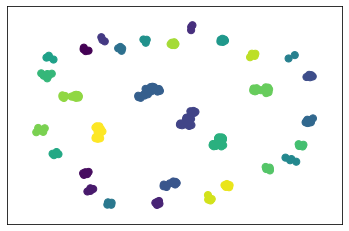

In [6]:
community_detection(G)

In [7]:
G = Graph(df_ext_2017)
draw_graph3(G, output_filename="plots/df_ext_2017.html", notebook=True)

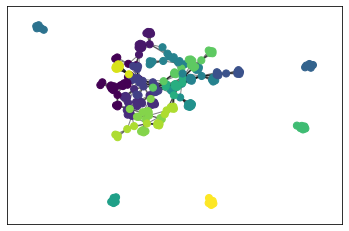

In [8]:
community_detection(G)

In [9]:
H, alpha = nx.complete_to_chordal_graph(G)

In [10]:
nx.is_chordal(H)

True

# Sankey diagram and Chord plot

In [11]:
# Sankey diagram
label = ["B2", "ERASMUS", "B3", "ING1", "B4", "ERASMUS", "EW", "ING2"]
source = [1, 0, 0 , 0, 2, 2 , 3]
target = [2, 6, 2 , 3, 5, 4 , 7]
value  = [4, 1, 13, 5, 4, 13, 5]
# data to dict, dict to sankey
link = dict(source = source, target = target, value = value)
node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label,
    )
data = go.Sankey(link = link, node=node)
# plot
fig = go.Figure(data)
fig.show()

In [12]:
# Sankey diagram

# Market basket analysis

In [55]:
df = pd.read_csv("datasets/tel_samp_rec.csv", encoding='latin-1', low_memory=False)

In [56]:
df_disc1 = df.loc[:, ['disc1.rec.lev1']].reset_index().rename(columns={"disc1.rec.lev1": "disc"})
df_disc1.loc[:, 'quantity'] = 1
df_disc2 = df.loc[:, ['disc2.rec.lev1']].reset_index().rename(columns={"disc2.rec.lev1": "disc"})
df_disc2.loc[:, 'quantity'] = 1
df_disc3 = df.loc[:, ['disc3.rec.lev1']].reset_index().rename(columns={"disc3.rec.lev1": "disc"})
df_disc3.loc[:, 'quantity'] = 1
df = pd.concat([df_disc1, df_disc2, df_disc3])
#df.drop().head()

In [74]:
transactions = df.drop(columns=['quantity']).rename(columns={"index":"trans_id", "disc":"item_id"})
transactions = transactions.dropna().drop_duplicates()
transactions = transactions[['item_id', 'trans_id']]
transactions.to_csv('datasets/transactions.csv')

In [75]:
transactions

,item_id,trans_id
0,X,0
1,IV,1
2,X,2
3,V,3
4,V,4
...,...,...
99688,VI,99688
99801,IX,99801
99861,V,99861
99912,V,99912


In [57]:
basket = df.groupby(['index', 'disc'])['quantity'].sum().unstack().reset_index().fillna(0).set_index('index')
basket.head()

disc,I,I - Droit,II,III,IV,IX,V,VI,VII,VIII,X,XII,pharmacie
index,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units) # Encode the basket
basket_sets = basket_sets[basket_sets.sum(axis=1) > 1] # Only keep transaction that has more than 1 item

In [59]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Compute the frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support = 0.03, 
                            use_colnames = True)

# Compute rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

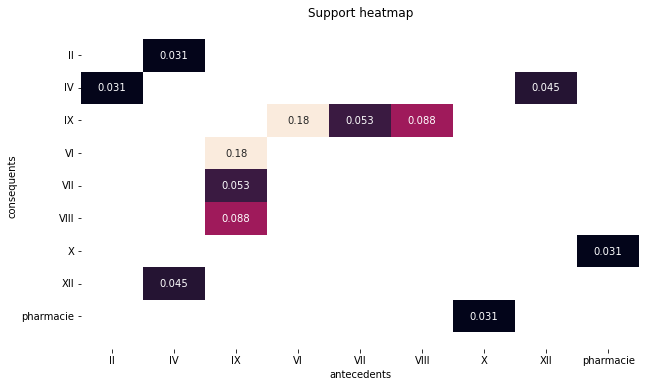

In [21]:
import seaborn as sns

# Convert antecedents and consequents into strings
rules['antecedents'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform antecedent, consequent, and support columns into matrix
support_table = rules.pivot(index='consequents', columns='antecedents', values='support')

plt.figure(figsize=(10,6))
sns.heatmap(support_table, annot=True, cbar=False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
# Add title and axis names
plt.title('Support heatmap')
plt.show()

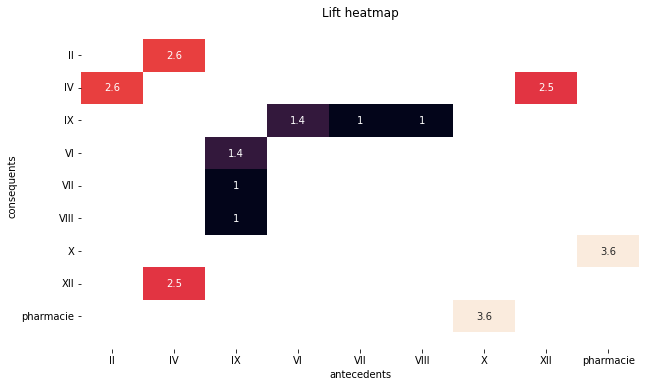

In [22]:
# Transform antecedent, consequent, and support columns into matrix
lift_table = rules.pivot(index='consequents', columns='antecedents', values='lift')

plt.figure(figsize=(10,6))
sns.heatmap(lift_table, annot=True, cbar=False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.title('Lift heatmap')
plt.show()

In [23]:
# Function to convert rules to coordinates.
def rules_to_coordinates(rules):
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])
    rules['rule'] = rules.index
    return rules[['antecedent','consequent','rule']]

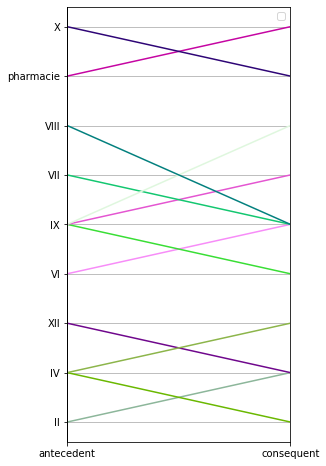

In [24]:
from pandas.plotting import parallel_coordinates

# Compute the frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support = 0.03, 
                            use_colnames = True)

# Compute rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Convert rules into coordinates suitable for use in a parallel coordinates plot
coords = rules_to_coordinates(rules)

# Generate parallel coordinates plot
plt.figure(figsize=(4,8))
parallel_coordinates(coords, 'rule')
plt.legend([])
plt.grid(True)
plt.show()